### Preparation steps

Install iotfunctions with

`pip install git+https://github.com/ibm-watson-iot/functions@development`

This projects contains the code for the Analytics Service pipeline as well as the anomaly functions and should pull in most of this notebook's dependencies.

The plotting library matplotlib is the exception, so you need to run
`pip install matplotlib`


In [1]:
# Real life data

import logging
import threading
import itertools
import math
import datetime
import pandas as pd  
import numpy as np  
import scipy as sp
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.bif import PythonExpression
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from iotfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore,
                 SaliencybasedGeneralizedAnomalyScoreV2, FFTbasedGeneralizedAnomalyScoreV2, 
                 KMeansAnomalyScoreV2, BayesRidgeRegressor,)
from mmfunctions.anomaly import (FeatureBuilder, GBMForecaster, KDEAnomalyScore, VIAnomalyScore)
from poc.functions import State_Timer
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [2]:
# set up a db object with a FileModelStore to support scaling
with open('credentials_as_monitor_demo.json', encoding='utf-8') as F:
    credentials = json.loads(F.read())
db_schema=None
fm = FileModelStore()
db = Database(credentials=credentials, model_store=fm)
print (db)

2020-12-16T10:27:50.245 INFO iotfunctions.dbtables.__init__ Init FileModelStore


In [25]:
def load_data(filename):
    # load data
    df_input = pd.read_csv(filename, parse_dates=['RCV_TIMESTAMP_UTC'], comment='#')
    #df_input = df_input.asfreq('H')
    df_input = df_input.sort_values(by='RCV_TIMESTAMP_UTC').\
                    rename(columns={'RCV_TIMESTAMP_UTC':'timestamp', 'DEVICEID': 'entity'}).\
                    drop(columns=['DEVICETYPE','ID','FORMAT','UPDATED_UTC','LOGICALINTERFACE_ID','PUMP_MODE',\
                                  'DEVICE_ID','FIRMWARE_VER','PTS_COUNT','SERIAL_NUMBER', 'HARDWARE_VER',\
                                  'TAG_NUMBER','PWR','HW_VER','DQ','FW_VER','PTS','PERF_OPTION']).\
                    drop(columns=['VIBRATION_N_XAXIS','VIBRATION_N_YAXIS','VIBRATION_N_ZAXIS','REATED_POWER',\
                                  'RATED_SPEED','RATED_CURRENT','RMSN_X','RMSN_Y','RMSN_Z','RUN_QTY',\
                                  'DESIGN_HEAD','DESIGN_FLOW','RMS_X_AVG'])

    df_input = df_input[df_input['VERSION'] != 0].drop(columns=['VERSION'])
    
    
    return df_input

    
def prep_data(df_input):
    entity = df_input['entity'].values[0]
    
    list_ac_vx = []
    cnt = 0
    for idx,row in df_input[['timestamp','VIBRATIONS_XAXIS','ACCEL_POWER']].iterrows():
        ts = datetime.datetime.strptime(row['timestamp'], '%Y-%m-%d-%H.%M.%S.%f')
        rvibs = row['VIBRATIONS_XAXIS']
        racc = row['ACCEL_POWER']
        if isinstance(rvibs, str):
            list_ac = []

            for ac in eval(racc):
                #print(ac)
                list_ac.append(eval(ac))
                list_ac.append(eval(ac))
                list_ac.append(eval(ac))
                #print (list_ac)

            list_vx = []
            for vx in eval(rvibs):
                list_vx.append(vx)
                #print (list_vx)

            #print(list_ac, list_vx)
            cnt2 = 0
            for p in zip(list_ac, list_vx):
                #print(ts + datetime.timedelta(seconds = cnt2 * 10), p[0],p[1])
                list_ac_vx.append([ts + datetime.timedelta(seconds = cnt2 * 10), p[0],p[1]])
                cnt2 += 1
        cnt += 1

    df_clean = pd.DataFrame(list_ac_vx, columns=['timestamp','Ap','Vx'])
    df_clean['entity'] = entity
    
    return df_clean.set_index(['entity','timestamp'])
    

In [26]:
df_clean = prep_data(load_data('./IOT_PUMP_DE_GEN5_202012141519.csv'))

df_clean.head(2)

Ap      Vx
entity       timestamp                              
04714B601096 2019-12-17 10:11:47.919  3.3366 -0.1035
             2019-12-17 10:11:57.919  3.3366 -0.0361

In [30]:
df_clean.index.levels[0].values[0]

'04714B601096'

<Figure size 1152x432 with 0 Axes>

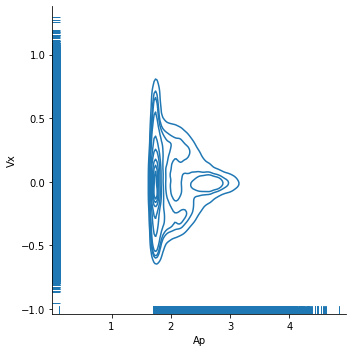

In [33]:
import seaborn as sns

plt.figure(figsize=(16, 6))
g = sns.displot(df_clean[['Ap','Vx']], x='Ap', y='Vx', kind="kde", rug=True)
    
g.set_titles('KDE for' + df_clean.index.levels[0].values[0])

In [34]:
df_i = df_clean.copy()

In [35]:
%%time
print('Train and evaluate model for ' + df_i.index.levels[0].values[0])
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi = VIAnomalyScore(['Ap'], ['Vx'])
et = spsi._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
spsi._entity_type = et
df_i = spsi.execute(df=df_i)

EngineLogging.configure_console_logging(logging.INFO)
df_i.describe()

Train and evaluate model for 04714B601096
2020-12-16T11:01:58.236 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2020-12-16T11:01:58.237 DEBUG mmfunctions.anomaly.__init__ init KDE Estimator
2020-12-16T11:01:58.237 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.2.1
2020-12-16T11:01:58.238 DEBUG iotfunctions.util.__init__ Starting trace
2020-12-16T11:01:58.239 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_VIAnomalyScore_20201216100158
2020-12-16T11:01:58.239 DEBUG iotfunctions.util.__init__ auto_save None
2020-12-16T11:01:58.240 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-12-16T11:01:58.240 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-12-16T11:01:58.241 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEnti

2020-12-16T11:06:21.063 DEBUG mmfunctions.anomaly.execute Epoch: 720, Loss: 0.6499183773994446
2020-12-16T11:06:27.231 DEBUG mmfunctions.anomaly.execute Epoch: 730, Loss: 0.650270402431488
2020-12-16T11:06:33.740 DEBUG mmfunctions.anomaly.execute Epoch: 740, Loss: 0.650188148021698
2020-12-16T11:06:40.307 DEBUG mmfunctions.anomaly.execute Epoch: 750, Loss: 0.6516507863998413
2020-12-16T11:06:46.896 DEBUG mmfunctions.anomaly.execute Epoch: 760, Loss: 0.6498392820358276
2020-12-16T11:06:54.156 DEBUG mmfunctions.anomaly.execute Epoch: 770, Loss: 0.6515682935714722
2020-12-16T11:07:01.036 DEBUG mmfunctions.anomaly.execute Epoch: 780, Loss: 0.6518018841743469
2020-12-16T11:07:07.461 DEBUG mmfunctions.anomaly.execute Epoch: 790, Loss: 0.6505151987075806
2020-12-16T11:07:14.372 DEBUG mmfunctions.anomaly.execute Epoch: 800, Loss: 0.6503372192382812
2020-12-16T11:07:20.559 DEBUG mmfunctions.anomaly.execute Epoch: 810, Loss: 0.6506216526031494
2020-12-16T11:07:26.607 DEBUG mmfunctions.anomaly.ex

<ipython-input-35-ebaa636e8370>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  get_ipython().run_cell_magic('time', '', "print('Train and evaluate model for ' + df_i.index.levels[0].values[0])\n# Now run the anomaly functions as if they were executed in a pipeline\nEngineLogging.configure_console_logging(logging.DEBUG)\njobsettings = { 'db': db, \n               '_db_schema': 'public', 'save_trace_to_file' : True}\n\nspsi = VIAnomalyScore(['Ap'], ['Vx'])\net = spsi._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)\nspsi._entity_type = et\ndf_i = spsi.execute(df=df_i)\n\nEngineLogging.configure_console_logging(logging.INFO)\ndf_i.describe()\n")


,Ap,Vx,predicted_Vx,pred_dev_Vx
count,430290.000000,430290.000000,430290.000000,430290.000000
mean,1.921440,-0.006829,-0.005975,0.779265
std,0.324419,0.236620,0.000699,0.095900
min,0.115600,-0.956100,-0.015145,0.082666
25%,1.732000,-0.146500,-0.006131,0.770269
50%,1.758800,-0.016600,-0.005618,0.791205
75%,1.982000,0.123000,-0.005556,0.819832
max,4.836800,1.297900,-0.005503,0.906836


2020-12-16T11:16:25.069 WARNING matplotlib.legend._parse_legend_args No handles with labels found to put in legend.


Text(0.5, 1.0, 'pump 04714B601096 - plain scatterplot')

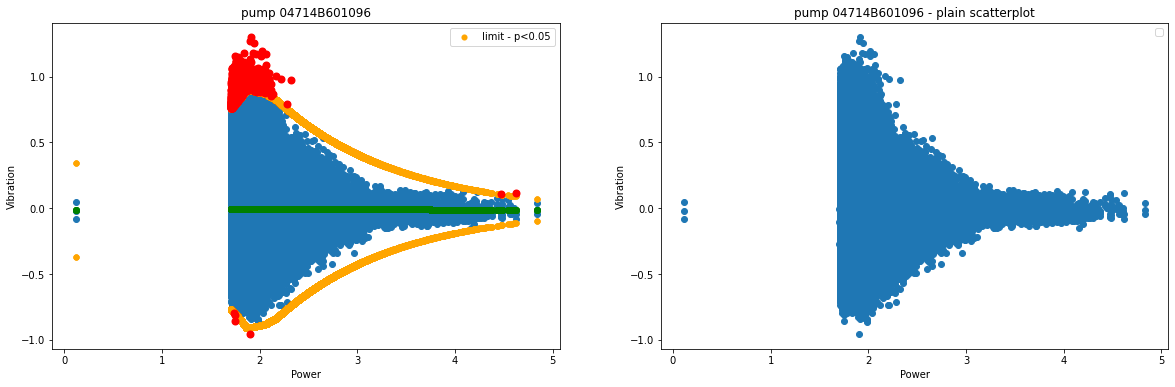

In [37]:
df_1 = df_i.loc[df_i.index.levels[0].values[0]].copy()

arr1 = np.where(df_1['Vx'] > df_1['predicted_Vx'] + df_1['pred_dev_Vx'], df_1['Vx'], 0) + \
       np.where(df_1['Vx'] < df_1['predicted_Vx'] - df_1['pred_dev_Vx'], df_1['Vx'], 0)
arr1[arr1 == 0] = np.nan
df_1['Anomaly'] = arr1

fig, ax = plt.subplots(1, 2, figsize=(20, 6), squeeze=False)

ax[0,0].scatter(df_1['Ap'], df_1['Vx'])
ax[0,0].scatter(df_1['Ap'], df_1['predicted_Vx'], color='green')
ax[0,0].scatter(df_1['Ap'], df_1['predicted_Vx'] - df_1['pred_dev_Vx'], color='orange', lw=0.1, label='limit - p<0.05')
ax[0,0].scatter(df_1['Ap'], df_1['predicted_Vx'] + df_1['pred_dev_Vx'], color='orange', lw=0.1)
ax[0,0].scatter(df_1['Ap'], df_1['Anomaly'], color='red', lw=2)
ax[0,0].set_xlabel('Power')
ax[0,0].set_ylabel('Vibration')
ax[0,0].legend()
ax[0,0].set_title('pump ' + df_i.index.levels[0].values[0])

ax[0,1].scatter(df_i['Ap'], df_clean['Vx'])
ax[0,1].set_xlabel('Power')
ax[0,1].set_ylabel('Vibration')
ax[0,1].legend()
ax[0,1].set_title('pump ' + df_i.index.levels[0].values[0] + ' - plain scatterplot')


#plt.fill_between(df_1['Ap'], - df_1['pred_dev_Vx'], df_1['pred_dev_Vx'], alpha=0.2)

Text(0.5, 1.0, 'pump 04714B601096')

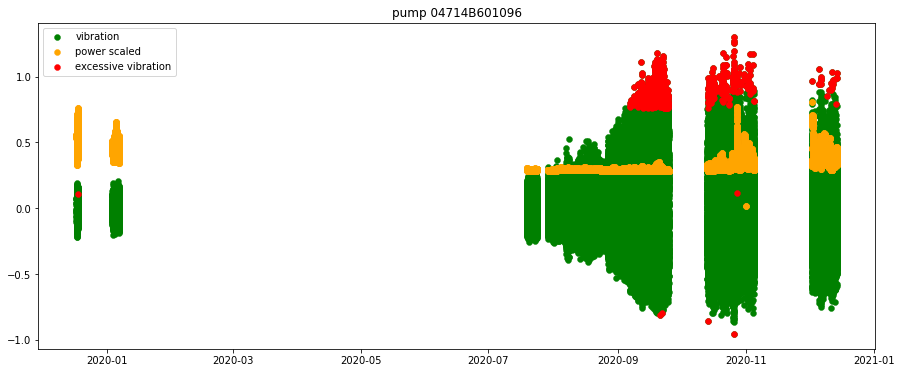

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6), squeeze=False)
#ax[0,0].plot(df_1['max'] + 2.0, lw=0.4, color='blue', label='smoothed max vib + 1')
ax[0,0].scatter(df_1.index,df_1['Vx'], lw=0.4, color='green', label='vibration')
ax[0,0].scatter(df_1.index,df_1['Ap']/6, lw=0.4, color='orange', zorder=5, label='power scaled')
ax[0,0].scatter(df_1.index, df_1['Anomaly'], lw=0.4, color='red', zorder=10, label='excessive vibration')
ax[0,0].legend()
ax[0,0].set_title('pump ' + df_i.index.levels[0].values[0])

In [39]:
df_clean2 = prep_data(load_data('./IOT_PUMP_DE_GEN5_202012151526.csv'))
df_clean2.head(2)
df_clean2.index.levels[0].values[0]

'04714B603408'

<Figure size 1152x432 with 0 Axes>

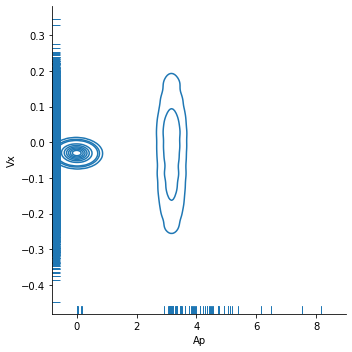

In [40]:
import seaborn as sns

plt.figure(figsize=(16, 6))
g = sns.displot(df_clean2[['Ap','Vx']], x='Ap', y='Vx', kind="kde", rug=True)
    
g.set_titles('KDE for' + df_clean2.index.levels[0].values[0])

In [41]:
df_i2 = df_clean2.copy()

In [42]:
%%time
print('Train and evaluate model for ' + df_i2.index.levels[0].values[0])
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi2 = VIAnomalyScore(['Ap'], ['Vx'])
et = spsi2._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
spsi2._entity_type = et
df_i2 = spsi.execute(df=df_i2)

EngineLogging.configure_console_logging(logging.INFO)
df_i2.describe()

Train and evaluate model for 04714B603408
2020-12-16T11:17:25.093 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2020-12-16T11:17:25.094 DEBUG mmfunctions.anomaly.__init__ init KDE Estimator
2020-12-16T11:17:25.095 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.2.1
2020-12-16T11:17:25.095 DEBUG iotfunctions.util.__init__ Starting trace
2020-12-16T11:17:25.096 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_VIAnomalyScore_20201216101725
2020-12-16T11:17:25.096 DEBUG iotfunctions.util.__init__ auto_save None
2020-12-16T11:17:25.097 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-12-16T11:17:25.098 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-12-16T11:17:25.098 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEnti

2020-12-16T11:17:34.384 DEBUG mmfunctions.anomaly.execute Epoch: 710, Loss: 0.44914132356643677
2020-12-16T11:17:34.536 DEBUG mmfunctions.anomaly.execute Epoch: 720, Loss: 0.44947150349617004
2020-12-16T11:17:34.667 DEBUG mmfunctions.anomaly.execute Epoch: 730, Loss: 0.46284136176109314
2020-12-16T11:17:34.800 DEBUG mmfunctions.anomaly.execute Epoch: 740, Loss: 0.46134865283966064
2020-12-16T11:17:34.928 DEBUG mmfunctions.anomaly.execute Epoch: 750, Loss: 0.4522288739681244
2020-12-16T11:17:35.056 DEBUG mmfunctions.anomaly.execute Epoch: 760, Loss: 0.4621221423149109
2020-12-16T11:17:35.182 DEBUG mmfunctions.anomaly.execute Epoch: 770, Loss: 0.4568221867084503
2020-12-16T11:17:35.308 DEBUG mmfunctions.anomaly.execute Epoch: 780, Loss: 0.45526111125946045
2020-12-16T11:17:35.433 DEBUG mmfunctions.anomaly.execute Epoch: 790, Loss: 0.4548816680908203
2020-12-16T11:17:35.557 DEBUG mmfunctions.anomaly.execute Epoch: 800, Loss: 0.4472365379333496
2020-12-16T11:17:35.683 DEBUG mmfunctions.ano

CPU times: user 1min 53s, sys: 228 ms, total: 1min 53s
Wall time: 19 s


,Ap,Vx,predicted_Vx,pred_dev_Vx
count,16515.000000,16515.000000,16515.000000,16515.000000
mean,0.747944,-0.031219,-0.030281,0.230632
std,1.366269,0.057597,0.001342,0.168729
min,0.000000,-0.446300,-0.071604,0.137747
25%,0.000000,-0.037100,-0.029966,0.137747
50%,0.000000,-0.030300,-0.029966,0.137747
75%,0.000000,-0.022500,-0.029966,0.137747
max,8.173201,0.346700,-0.028944,0.634781


2020-12-16T11:20:11.115 WARNING matplotlib.legend._parse_legend_args No handles with labels found to put in legend.


Text(0.5, 1.0, 'pump 04714B603408 - plain scatterplot')

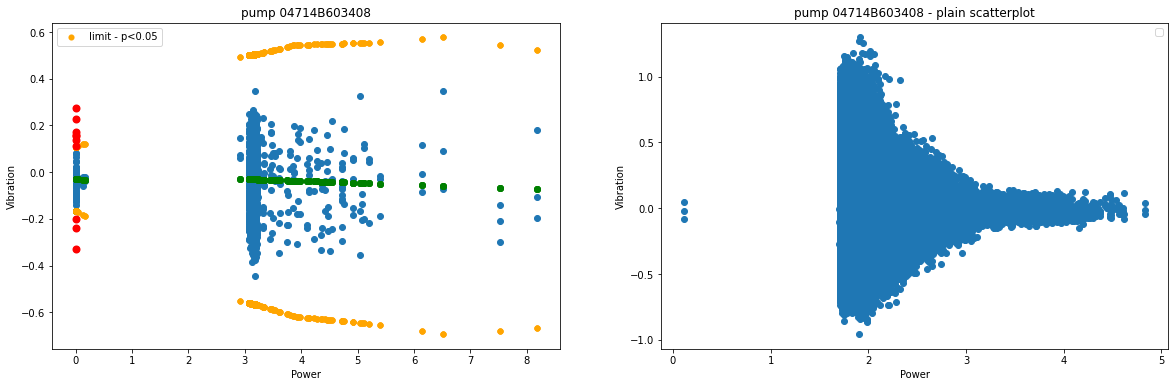

In [45]:
entity = df_i2.index.levels[0].values[0]

df_1 = df_i2.loc[entity].copy()


arr1 = np.where(df_1['Vx'] > df_1['predicted_Vx'] + df_1['pred_dev_Vx'], df_1['Vx'], 0) + \
       np.where(df_1['Vx'] < df_1['predicted_Vx'] - df_1['pred_dev_Vx'], df_1['Vx'], 0)
arr1[arr1 == 0] = np.nan
df_1['Anomaly'] = arr1

fig, ax = plt.subplots(1, 2, figsize=(20, 6), squeeze=False)

ax[0,0].scatter(df_1['Ap'], df_1['Vx'])
ax[0,0].scatter(df_1['Ap'], df_1['predicted_Vx'], color='green')
ax[0,0].scatter(df_1['Ap'], df_1['predicted_Vx'] - df_1['pred_dev_Vx'], color='orange', lw=0.1, label='limit - p<0.05')
ax[0,0].scatter(df_1['Ap'], df_1['predicted_Vx'] + df_1['pred_dev_Vx'], color='orange', lw=0.1)
ax[0,0].scatter(df_1['Ap'], df_1['Anomaly'], color='red', lw=2)
ax[0,0].set_xlabel('Power')
ax[0,0].set_ylabel('Vibration')
ax[0,0].legend()
ax[0,0].set_title('pump ' + entity)

ax[0,1].scatter(df_i['Ap'], df_clean['Vx'])
ax[0,1].set_xlabel('Power')
ax[0,1].set_ylabel('Vibration')
ax[0,1].legend()
ax[0,1].set_title('pump ' + entity + ' - plain scatterplot')


Text(0.5, 1.0, 'pump 04714B603408')

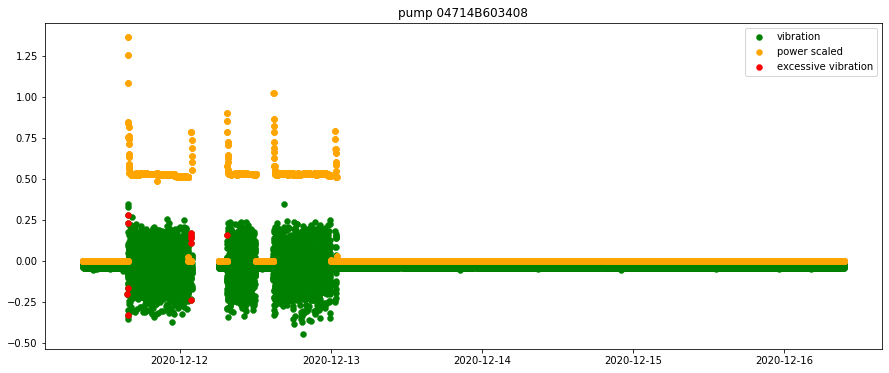

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6), squeeze=False)
#ax[0,0].plot(df_1['max'] + 2.0, lw=0.4, color='blue', label='smoothed max vib + 1')
ax[0,0].scatter(df_1.index,df_1['Vx'], lw=0.4, color='green', label='vibration')
ax[0,0].scatter(df_1.index,df_1['Ap']/6, lw=0.4, color='orange', zorder=5, label='power scaled')
ax[0,0].scatter(df_1.index, df_1['Anomaly'], lw=0.4, color='red', zorder=10, label='excessive vibration')
ax[0,0].legend()
ax[0,0].set_title('pump ' + df_i2.index.levels[0].values[0])

In [48]:
df_clean3 = prep_data(load_data('./IOT_PUMP_DE_GEN5_202012161027.csv'))
df_clean3.head(2)
df_clean3.index.levels[0].values[0]

'04714B6036B1'

<Figure size 1152x432 with 0 Axes>

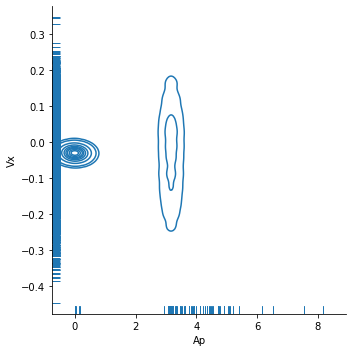

In [49]:
plt.figure(figsize=(16, 6))
g = sns.displot(df_clean3[['Ap','Vx']], x='Ap', y='Vx', kind="kde", rug=True)
    
g.set_titles('KDE for' + df_clean3.index.levels[0].values[0])

In [50]:
df_i3 = df_clean3.copy()

In [51]:
%%time
print('Train and evaluate model for ' + df_i3.index.levels[0].values[0])
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi3 = VIAnomalyScore(['Ap'], ['Vx'])
et = spsi3._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
spsi3._entity_type = et
df_i3 = spsi.execute(df=df_i3)

EngineLogging.configure_console_logging(logging.INFO)
df_i3.describe()

Train and evaluate model for 04714B6036B1
2020-12-16T11:25:09.127 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2020-12-16T11:25:09.128 DEBUG mmfunctions.anomaly.__init__ init KDE Estimator
2020-12-16T11:25:09.129 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.2.1
2020-12-16T11:25:09.129 DEBUG iotfunctions.util.__init__ Starting trace
2020-12-16T11:25:09.130 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_VIAnomalyScore_20201216102509
2020-12-16T11:25:09.130 DEBUG iotfunctions.util.__init__ auto_save None
2020-12-16T11:25:09.131 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-12-16T11:25:09.131 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-12-16T11:25:09.132 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEnti

2020-12-16T11:25:19.051 DEBUG mmfunctions.anomaly.execute Epoch: 710, Loss: 0.44599291682243347
2020-12-16T11:25:19.176 DEBUG mmfunctions.anomaly.execute Epoch: 720, Loss: 0.44785499572753906
2020-12-16T11:25:19.306 DEBUG mmfunctions.anomaly.execute Epoch: 730, Loss: 0.4528734087944031
2020-12-16T11:25:19.452 DEBUG mmfunctions.anomaly.execute Epoch: 740, Loss: 0.439583957195282
2020-12-16T11:25:19.587 DEBUG mmfunctions.anomaly.execute Epoch: 750, Loss: 0.4491921365261078
2020-12-16T11:25:19.721 DEBUG mmfunctions.anomaly.execute Epoch: 760, Loss: 0.44908633828163147
2020-12-16T11:25:19.861 DEBUG mmfunctions.anomaly.execute Epoch: 770, Loss: 0.45569461584091187
2020-12-16T11:25:20.001 DEBUG mmfunctions.anomaly.execute Epoch: 780, Loss: 0.4526123106479645
2020-12-16T11:25:20.138 DEBUG mmfunctions.anomaly.execute Epoch: 790, Loss: 0.4459758996963501
2020-12-16T11:25:20.271 DEBUG mmfunctions.anomaly.execute Epoch: 800, Loss: 0.4575124680995941
2020-12-16T11:25:20.401 DEBUG mmfunctions.anoma

CPU times: user 1min 59s, sys: 220 ms, total: 2min
Wall time: 20.1 s


,Ap,Vx,predicted_Vx,pred_dev_Vx
count,19890.000000,19890.000000,19890.000000,19890.000000
mean,0.621031,-0.031102,-0.030673,0.210081
std,1.276225,0.052576,0.001538,0.156773
min,0.000000,-0.446300,-0.076725,0.133384
25%,0.000000,-0.037100,-0.030209,0.133384
50%,0.000000,-0.030300,-0.030209,0.133384
75%,0.000000,-0.023400,-0.030209,0.133384
max,8.173201,0.346700,-0.030016,0.668509


2020-12-16T11:26:12.195 WARNING matplotlib.legend._parse_legend_args No handles with labels found to put in legend.


Text(0.5, 1.0, 'pump 04714B6036B1 - plain scatterplot')

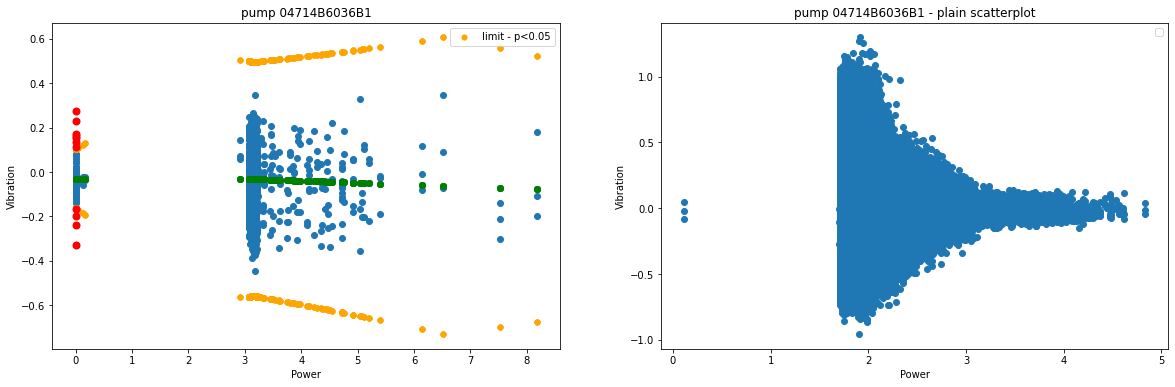

In [52]:
entity = df_i3.index.levels[0].values[0]

df_1 = df_i3.loc[entity].copy()


arr1 = np.where(df_1['Vx'] > df_1['predicted_Vx'] + df_1['pred_dev_Vx'], df_1['Vx'], 0) + \
       np.where(df_1['Vx'] < df_1['predicted_Vx'] - df_1['pred_dev_Vx'], df_1['Vx'], 0)
arr1[arr1 == 0] = np.nan
df_1['Anomaly'] = arr1

fig, ax = plt.subplots(1, 2, figsize=(20, 6), squeeze=False)

ax[0,0].scatter(df_1['Ap'], df_1['Vx'])
ax[0,0].scatter(df_1['Ap'], df_1['predicted_Vx'], color='green')
ax[0,0].scatter(df_1['Ap'], df_1['predicted_Vx'] - df_1['pred_dev_Vx'], color='orange', lw=0.1, label='limit - p<0.05')
ax[0,0].scatter(df_1['Ap'], df_1['predicted_Vx'] + df_1['pred_dev_Vx'], color='orange', lw=0.1)
ax[0,0].scatter(df_1['Ap'], df_1['Anomaly'], color='red', lw=2)
ax[0,0].set_xlabel('Power')
ax[0,0].set_ylabel('Vibration')
ax[0,0].legend()
ax[0,0].set_title('pump ' + entity)

ax[0,1].scatter(df_i['Ap'], df_clean['Vx'])
ax[0,1].set_xlabel('Power')
ax[0,1].set_ylabel('Vibration')
ax[0,1].legend()
ax[0,1].set_title('pump ' + entity + ' - plain scatterplot')


Text(0.5, 1.0, 'pump 04714B6036B1')

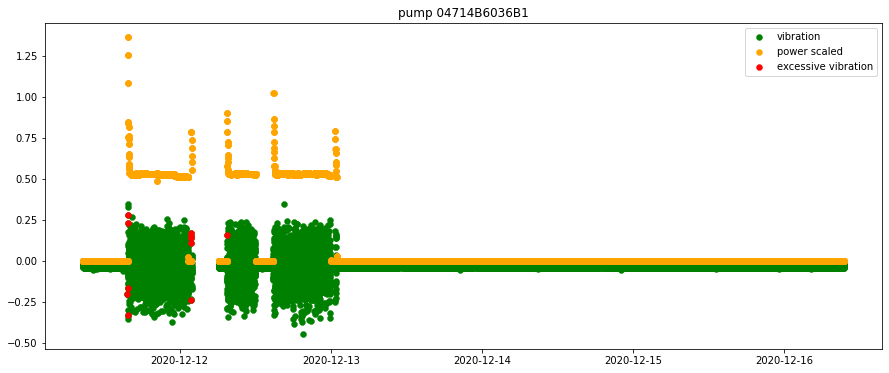

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6), squeeze=False)
#ax[0,0].plot(df_1['max'] + 2.0, lw=0.4, color='blue', label='smoothed max vib + 1')
ax[0,0].scatter(df_1.index,df_1['Vx'], lw=0.4, color='green', label='vibration')
ax[0,0].scatter(df_1.index,df_1['Ap']/6, lw=0.4, color='orange', zorder=5, label='power scaled')
ax[0,0].scatter(df_1.index, df_1['Anomaly'], lw=0.4, color='red', zorder=10, label='excessive vibration')
ax[0,0].legend()
ax[0,0].set_title('pump ' + df_i3.index.levels[0].values[0])

#### Approximate with Gaussian

major contribution: gaussian along x/y coordinates, start with diagonal covariance matrix:

likelihood:

$e^{\frac{ {(\mu_0 - x)}^2}{\sigma_0} \frac{ {(\mu_1 - y)}^2}{\sigma_1}  }$


ModuleNotFoundError: No module named 'tensorflow.contrib'

In [ ]:
# theta_0, theta_1 = mu_0/mu_1, theta_2/theta_3 = sigma_0/ sigma_1
def log_likelihood(theta, F, e):
    
    
    return np.sum(theta[0]
        
        np.log(2 * np.pi * (theta[1] ** 2 + theta[2] ** 2))
                         + (theta[0]) ** 2 / (theta[1] ** 2 + theta[2] ** 2))



def log_prior(theta):
    # sigma needs to be positive.
    if theta[1] <= 0:
        return -np.inf
    else:
        return 0

def log_posterior(theta, F, e):
    return log_prior(theta) + log_likelihood(theta, F, e)

# same setup as above:
ndim, nwalkers = 2, 50
nsteps, nburn = 2000, 1000

starting_guesses = np.random.rand(nwalkers, ndim)
starting_guesses[:, 0] *= 2000  # start mu between 0 and 2000
starting_guesses[:, 1] *= 20    # start sigma between 0 and 20

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, 2)